# VCF - Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [1]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile
from numba import jit

In [2]:
class Simulator(object):
    def __init__(self, amplitude=2**15-1, yrange=[-50, 10]):
        self.amplitude = amplitude
        self.yrange = yrange
        
        self.fig, self.ax1 = subplots(1, 1, figsize=[8, 4])
        
        # Load/generate data files
        self.sample_rate_Hz = 44100
        fs, x = scipy.io.wavfile.read("../app/sound/prbs20.wav")
        assert(fs == self.sample_rate_Hz)
        self.x_prbs20 = self.amplitude * x/(2**15)
        
        t = arange(len(self.x_prbs20)) / self.sample_rate_Hz
        self.x_chirp = self.amplitude * signal.chirp(t, f0=20, f1=20e3, t1=max(t), method="linear")
    
    def vcf(self, x, cutoff, resonance):
        # Example filter
        b, a = signal.cheby1(2, 10, 1000 * 2/self.sample_rate_Hz, btype="low")
        return signal.lfilter(b, a, x)
    
    def simulate_chirp(self, cutoff, resonance, gain=1.0):
        y = self.vcf(gain * self.x_chirp, cutoff, resonance)
        
        f = linspace(20, 20e3, len(y))
        #H = 1/self.amplitude * y
        H = 1/self.amplitude * signal.hilbert(y)

        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
        return 
    
    def simulate_prbs(self, cutoff, resonance, h_length=None):
        x = self.x_prbs20
        y = self.vcf(x, cutoff, resonance)
        
        if h_length is None:
            h_length = int(30/cutoff)

        t, h, f, H = self.analyze_prbs(x, y, h_length)
        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
    
    def analyze_prbs(self, x, y, h_length):
        # Estimate impulse response using a pseudo-random bit sequence.
        h = signal.correlate(y, x, "full")
        h = h[len(h)//2:]

        # Limit the impulse response length to lower the noise
        h = h[0:h_length]
        t = arange(h_length)/self.sample_rate_Hz

        # Estimate frequency response
        H = fft.fft(h)
        H = H[0:len(H)//2] 
        H /= max(abs(H))
        f = linspace(0.01, self.sample_rate_Hz/2, len(H))

        return t, h, f, H

    def plot_frequency_response(self, f, H, label=None):
        self.ax1.semilogx(f, 20*ma.log10(abs(H)), label=label)

    def show(self):
        # Frequency response graph
        self.ax1.grid(True, "both", "both")
        self.ax1.legend()
        self.ax1.set_xlim(20, 20e3)
        self.ax1.set_ylim(*self.yrange)
        
        self.fig.tight_layout()
        #self.fig.show()


In [3]:
@jit
def nb_onepole(x, g, x1, y1):
    v = 1/1.3 * x + 0.3/1.3*x1
    y = (v-y1)*g + y1
    return y

@jit
def upsample(x, N):
    y = [0]*(len(x)*N)
    for m in range(len(y)):
        if (m % N) == 0:
            y[m] = x[m//N]
        else:
            y[m] = 0
    return y

@jit
def downsample(x, N):
    y = zeros(len(x)//N)
    for m in range(len(y)):
        y[m] = x[m*N]
    return y

def interpolate_by_4(x):
    N = 4
    b = signal.firwin(24, 0.8/N)
    return signal.lfilter(b, [1.0], upsample(x, N))

def decimate_by_4(x):
    N = 4
    b = signal.firwin(24, 0.8/N)
    y = signal.lfilter(b, [1.0], x)
    return downsample(y, N)

## Voltage Controlled Filter

- Basic filter structure from Stilson and Smith 1996 Analyzing the Moog VCF with Considerations for Digital Implementation
- Referred to in Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis page 26.

In [4]:
@jit
def nb_nl_vcf(x, g, k):
    # Onepole delay points:
    # - Before op1
    # - After opN for N in 1...4
    y = [0]*len(x)
    w = [0, 0, 0, 0, 0] # Current sample
    d = [0, 0, 0, 0, 0] # Delayed sample
    
    # Feedback gain compensation form Valimaki
    G_comp = 0.5

    for n in range(1, len(y)):
        # Make headroom for resonance        
        x_ = x[n]
        w[0] = x_ - (d[4]*k - G_comp*x_)
        w[0] = 2**15 * tanh(w[0]/2**15)
        w[1] = nb_onepole(w[0], g, d[0], d[1])
        w[2] = nb_onepole(w[1], g, d[1], d[2])
        w[3] = nb_onepole(w[2], g, d[2], d[3])
        w[4] = nb_onepole(w[3], g, d[3], d[4])

        for i in range(5):
            d[i] = w[i]

        y[n] = w[4]

    return y

class VcfNonlinear(Simulator):
    def map_cutoff(self, value):
        assert(0 <= value <= 127)
        b = 0.005
        a = (0.2-b) / (127*127)
        return a*value*value + b

    def map_resonance(self, value):
        assert(0 <= value <= 127)
        b = 0.5
        a = (3.9-b) / 127
        return a*value + b
 
    def vcf(self, x, cutoff, resonance):
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        x = interpolate_by_4(x)
        y = nb_nl_vcf(x, g, k)
        y = decimate_by_4(y)
        return y

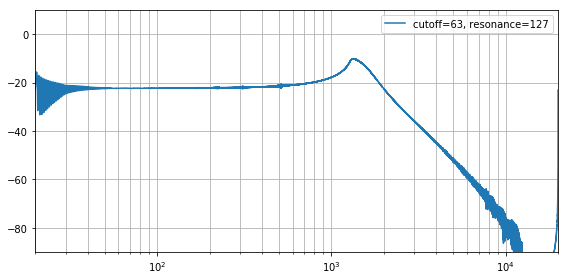

In [5]:
s = VcfNonlinear(yrange=[-90, 10])
cutoffs = [63]
resonances = [127]
for cutoff in cutoffs:
    for res in resonances:
        s.simulate_chirp(cutoff, res, gain=1)
        
s.show()